In [4]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import qtm.base, qtm.constant, qtm.nqubit, qtm.fubini_study, qtm.progress_bar

### GHZ

In [ ]:
num_qubits = 3
num_layers = 2
thetas = np.ones(num_qubits*num_layers*5)
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=100, disable=False)
for i in range(0, 100):
    bar.update(1)
    G = qtm.fubini_study.calculate_linear_state(qc.copy(), thetas, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_GHZchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers, theta = theta)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.pinv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_GHZchecker_linear(qc.copy(), thetas, num_layers, theta)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/loss_values_qng.csv", loss_values, delimiter=",")
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/thetass_qng.csv", thetass, delimiter=",")


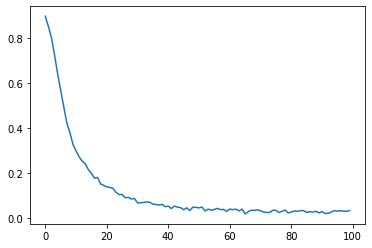

In [5]:
plt.plot(loss_values)

In [6]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_ghz_state(qc1, theta)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/traces_qng.csv", traces, delimiter=",")
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/fidelities_qng.csv", fidelities, delimiter=",")

# W

In [7]:
num_qubits = 3
num_layers = 2
thetas = np.zeros(num_qubits*num_layers*5)
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=100, disable=False)
for i in range(0, 100):
    bar.update(1)
    G = qtm.fubini_study.calculate_linear_state(qc.copy(), thetas, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Wchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.pinv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_Wchecker_linear(qc.copy(), thetas, num_layers)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/loss_values_qng.csv", loss_values, delimiter=",")
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/thetass_qng.csv", thetass, delimiter=",")


Step: 100%|██████████| 100/100 [22:36<00:00, 13.57s/it]


In [8]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_w_state(qc1)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/traces_qng.csv", traces, delimiter=",")
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/fidelities_qng.csv", fidelities, delimiter=",")

### Others

In [2]:
import os, qiskit, qtm.constant, qtm.nqubit, pandas as pd, numpy as np
path = "../experiments/linear_ansatz_w/"
dirs = os.listdir(path)
dirs = list(map(int, dirs))
dirs.sort()
num_layers = 2
for dir in dirs:
    dir = str(dir)
    num_qubits = int(dir)
    print(num_qubits)
    thetass = pd.read_csv(path + dir + "/thetass_qng.csv", sep=",", header=None).to_numpy()
    traces = []
    fidelities = []
    i = 0
    for thetas in thetass:
        # Get |psi> = U_gen|000...>
        qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
        qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
        psi, rho_psi = qtm.base.extract_state(qc)
        # Get |psi~> = U_target|000...>
        qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
        qc1 = qtm.nqubit.create_w_state(qc1)
        psi_hat, rho_psi_hat = qtm.base.extract_state(qc1)
        # Calculate the metrics
        trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
        traces.append(trace)
        fidelities.append(fidelity)
    np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/traces_qng.csv", traces, delimiter=",")
    np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/fidelities_qng.csv", fidelities, delimiter=",")

2
3
4
5
6
7
8
9
10


### Compare number of layers

In [2]:
num_qubits = 7
num_layers = 4
thetas = np.ones((num_qubits*num_layers*5))
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=200, disable=False)
for i in range(0, 200):
    bar.update(1)
    G = qtm.fubini_study.qng(qc.copy(), thetas, qtm.nqubit.create_linear_state, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_GHZchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers, theta = theta)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.inv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_GHZchecker_linear(qc.copy(), thetas, num_layers, theta)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/loss_values_qng" + str(num_layers) + ".csv", loss_values, delimiter=",")
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/thetass_qng" + str(num_layers) + ".csv", thetass, delimiter=",")


Step: 100%|██████████| 200/200 [1:48:39<00:00, 32.60s/it]


In [18]:
thetass_tmp = pd.read_csv("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/thetass_qng" + str(num_layers) + ".csv", sep=",", header=None).to_numpy()
loss_values_tmp = pd.read_csv("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/loss_values_qng" + str(num_layers) + ".csv", sep=",", header=None).to_numpy()
loss_values = []
for loss in loss_values_tmp:
    loss_values.append(loss[0])
num_qubits = 7
num_layers = 4
thetass = []
for thetas in thetass_tmp:
    thetass.append(thetas[0])

thetas = thetass[-1]
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
bar = qtm.progress_bar.ProgressBar(max_value=200, disable=False)
for i in range(0, 200):
    bar.update(1)
    G = qtm.fubini_study.qng(qc.copy(), thetas, qtm.nqubit.create_linear_state, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_GHZchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers, theta = theta)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.inv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_GHZchecker_linear(qc.copy(), thetas, num_layers, theta)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)

Step:   0%|          | 1/200 [07:18<24:14:48, 438.64s/it]


TypeError: object of type 'numpy.float64' has no len()

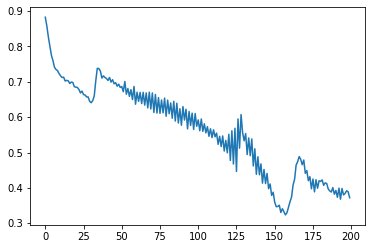

In [3]:
plt.plot(loss_values)

In [4]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_ghz_state(qc1, theta)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/traces_qng" + str(num_layers) + ".csv", traces, delimiter=",")
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/fidelities_qng" + str(num_layers) + ".csv", fidelities, delimiter=",")

In [5]:
num_qubits = 7
num_layers = 5
thetas = np.ones((num_qubits*num_layers*5))
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=200, disable=False)
for i in range(0, 200):
    bar.update(1)
    G = qtm.fubini_study.qng(qc.copy(), thetas, qtm.nqubit.create_linear_state, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Wchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.inv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_Wchecker_linear(qc.copy(), thetas, num_layers)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/loss_values_qng" + str(num_layers) + ".csv", loss_values, delimiter=",")
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/thetass_qng" + str(num_layers) + ".csv", thetass, delimiter=",")


Step: 100%|██████████| 200/200 [2:30:44<00:00, 45.22s/it]  


In [6]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_w_state(qc1)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/traces_qng" + str(num_layers) + ".csv", traces, delimiter=",")
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/fidelities_qng" + str(num_layers) + ".csv", fidelities, delimiter=",")